In [116]:
import neurom as nm
from neurom import viewer

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Tlx3-Cre_PL56_Ai14-338859.04.01.01_647469819_m.swc'}, xlabel='x', ylabel='y'>)

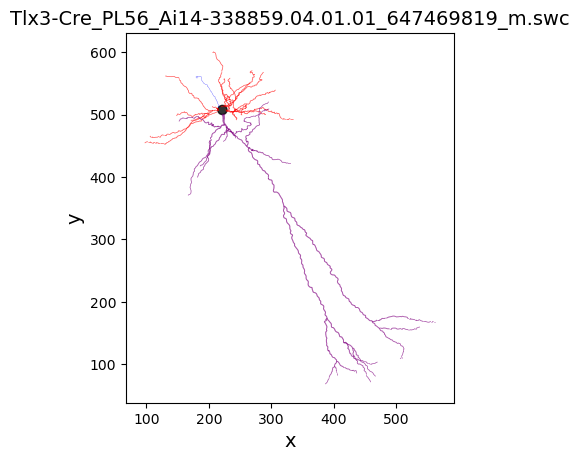

In [117]:
m = nm.load_morphology('../../data/allen/Tlx3-Cre_PL56_Ai14-338859.04.01.01_647469819_m.swc')
viewer.draw(m)

In [118]:
import neurom.features as nf
import numpy as np

def process_morphology(m):
    segments_per_section = []
    parents = []
    parent_indices = []
    points = []

    for section in m.sections:
        number_of_segments = nf.section.number_of_segments(section)
        segments_per_section.append(number_of_segments)

        if section.parent is None:
            parent_id = -1
            parent_index = 0
            parents.append(parent_id)
            parent_indices.append(parent_index)
        else:
            parent_id = section.parent.id
            parent_index = np.sum(segments_per_section[:parent_id])
            parents.append(parent_id)
            parent_indices.append(parent_index)

        points.append(section.points)

    parent_indices = np.concatenate([np.array([0], dtype=np.int64), parent_indices])
    result = []
    for idx, s in enumerate(segments_per_section):
        res = np.concatenate([
            np.array([parent_indices[idx]-1], dtype=np.int64), 
            np.arange(0, s) + np.array(segments_per_section[:idx], dtype=np.int64).sum()]
        )
        result.append(res)

    parents = np.concatenate(result, dtype=np.int64)
    points = np.vstack(points)

    return points, parents

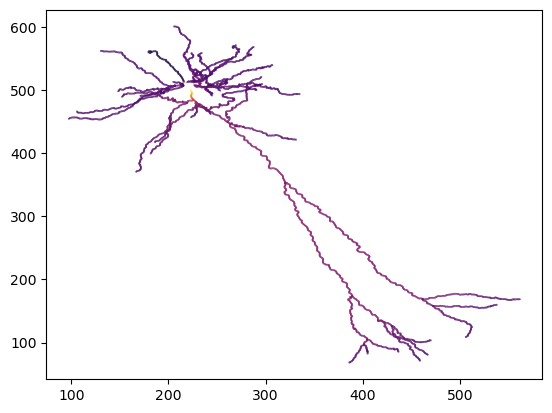

In [119]:
import matplotlib.pyplot as plt

cm = plt.get_cmap('inferno')
points, parents = process_morphology(m)
plt.scatter(points[:, 0], points[:, 1], s=.1, color=cm(points[:, 3]))

In [120]:
import jax.numpy as np
import tree_math
import dataclasses
from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.base.tree_solver import tree_solve, tree_matmul
from jaxsnn.base.types import ArrayLike
import matplotlib.pyplot as plt

In [6]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=-state.v + state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [66]:
import numpy as onp

N = len(parents)
dt = 1e-2
inner_steps = 1
outer_steps = 2048
time = dt * inner_steps * (1 + np.arange(outer_steps))

equation = MultiCompartmentNeuronModel(
    d=-2 * np.ones(N), u=np.ones(N - 1), p=parents
)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

initial_state = NeuronState(
    v=np.sin(np.linspace(0,5,N)), I=np.zeros(N)
)
_, actual = integrator(initial_state)

In [144]:
import matplotlib as mpl


def animate_fig(n_frames=300):
    fig = plt.figure()
    ax = fig.add_subplot()

    step = 0
    ax.set_axis_off()
    ax.scatter(points[:, 1], points[:, 0], s=.2, c=actual.v[step,:], cmap=cm, alpha=1.0)
    
    # ax.add_artist(mpl.patches.Circle(m.soma.center[:2], m.soma.radius, c=actual.v[step,0], alpha=1.0))
    fig.tight_layout()

    def update(step):
        ax.clear()
        ax.set_axis_off()
        ax.scatter(points[:, 1], points[:, 0], s=.2, c=actual.v[step,:], cmap=cm, alpha=1.0)
        # ax.add_artist(mpl.patches.Circle(m.soma.center[:2], m.soma.radius, c=actual.v[step,0], alpha=1.0))
        fig.tight_layout()
        return ax
    
    ani = mpl.animation.FuncAnimation(fig, update, frames=np.arange(0, n_frames, 1), interval=100)
    ani.save('passive_cable.gif', writer='ffmpeg', fps=30)

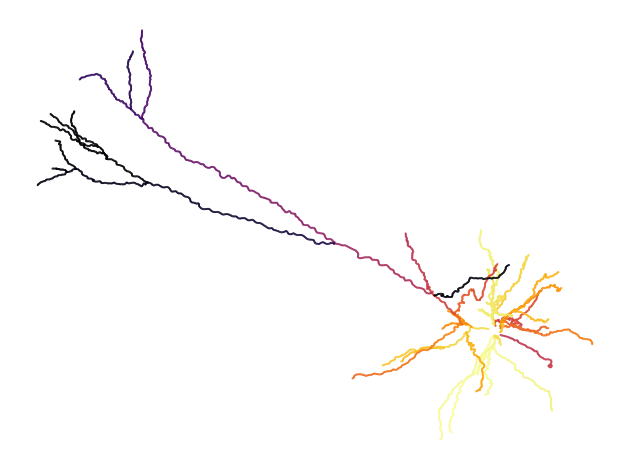

In [145]:
animate_fig(n_frames=30)